In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, f1_score, precision_score, recall_score, confusion_matrix, mean_squared_log_error
import lightgbm as lgb
import xgboost as xgb
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [567]:
# Clean Data Modeling
df_master = pd.read_csv("Master3_Anton_classification.csv")

In [568]:
df_master.drop("Unnamed: 0",axis=1,inplace=True)

In [569]:
df_master = df_master.rename(columns={"wrong budget":"inflation budget"})

In [570]:
X = df_master.drop("revenue",axis=1)

In [571]:
df_master['profit'] = df_master["revenue"] - 3 * df_master["budget"]
df_master["target"] = df_master["profit"].apply(lambda x: 1 if x >= 0 else 0)
df_master["target"].value_counts()

0    1943
1    1279
Name: target, dtype: int64

In [572]:
y = df_master["target"]

In [573]:
numb = 0
numbers = 0
nonumb = 0
for i in X.dtypes:
    if i == "int64":
        numb+=1
    elif i == "float64":
        numbers+= 1
    else:
        nonumb+= 1
print(numb,numbers,nonumb)

180 10 0


In [574]:
X_scaled_std = StandardScaler().fit_transform(X)

In [575]:
X_scaled_minmax = MinMaxScaler().fit_transform(X)

In [576]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_std,y, random_state=0)

In [547]:
#grid of parameters
gridParams = {
    'learning_rate': [0.01,0.02,0.03,0.04,0.05],
    'num_leaves': [90,150,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }

clf = lgb.LGBMRegressor()
grid = GridSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1)
grid.fit(X_train,y_train)

grid.best_params_


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  6.9min finished


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'learning_rate': 0.04,
 'max_depth': 7,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'num_leaves': 90,
 'objective': 'binary',
 'random_state': 501,
 'subsample': 0.5}

In [577]:
gridParams = {
    'boosting_type': ['gbdt'],
    'colsample_bytree': [0.7],
    'learning_rate': [0.05],
    'max_depth': [6],
    'metric': ['auc'],
    'min_data_in_leaf': [10],
    'min_split_gain': [0.01],
    'num_leaves': [90],
    'objective': ['binary'],
    'random_state': [501],
    'subsample': [0.5]}

clf = lgb.LGBMRegressor()
grid = GridSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1)
grid.fit(X_train,y_train)

grid.best_params_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'num_leaves': 90,
 'objective': 'binary',
 'random_state': 501,
 'subsample': 0.5}

In [578]:
#Prediction
y_pred = grid.predict(X_test)

In [586]:
# Check best threshold
threshold_value = []
accuracy_value = []
y_pred2 = []
for i in np.linspace(0,1,100):
    
    threshold = i
    for z in range(X_test.shape[0]):
        if y_pred[z] >= threshold:       
            y_pred2.append(1)
        else:  
            y_pred2.append(0)
        
    threshold_value.append(i)
   
    accuracy_value.append(accuracy_score(y_pred2,y_test))
    y_pred2 = []
df_threshold = pd.DataFrame(list(zip(threshold_value,accuracy_value)), columns=["threshold","accuracy"])

df_threshold[df_threshold["accuracy"] ==  df_threshold["accuracy"].max()]


,threshold,accuracy
47,0.474747,0.815136


In [587]:
# setting threshold to number
y_pred2 = []
threshold = 0.474747
for i in range(X_test.shape[0]):
    if y_pred[i] >= threshold:       
       y_pred2.append(1)
    else:  
       y_pred2.append(0)

In [588]:
# Evaluation metricks
print('AUC of LGB classifier on test set:{:.3f}\n'.format(roc_auc_score(y_test,y_pred)))
print('Accuracy of LGB  classifier on test set: {:.3f}\n'.format(accuracy_score(y_test,y_pred2)))
print('Precision of LGB  classifier on test set: {:.3f}\n'.format(precision_score(y_test,y_pred2)))
print('Recall of LGB  classifier on test set: {:.3f}\n'.format(recall_score(y_test,y_pred2)))
print('F1_score of LGB  classifier on test set: {:.3f}\n'.format(f1_score(y_test,y_pred2)))
print("Confusion matrix\n", confusion_matrix(y_test,y_pred2))

AUC of LGB classifier on test set:0.884

Accuracy of LGB  classifier on test set: 0.815

Precision of LGB  classifier on test set: 0.745

Recall of LGB  classifier on test set: 0.782

F1_score of LGB  classifier on test set: 0.763

Confusion matrix
 [[417  82]
 [ 67 240]]


Text(0, 0.5, 'Feature Importance Score')

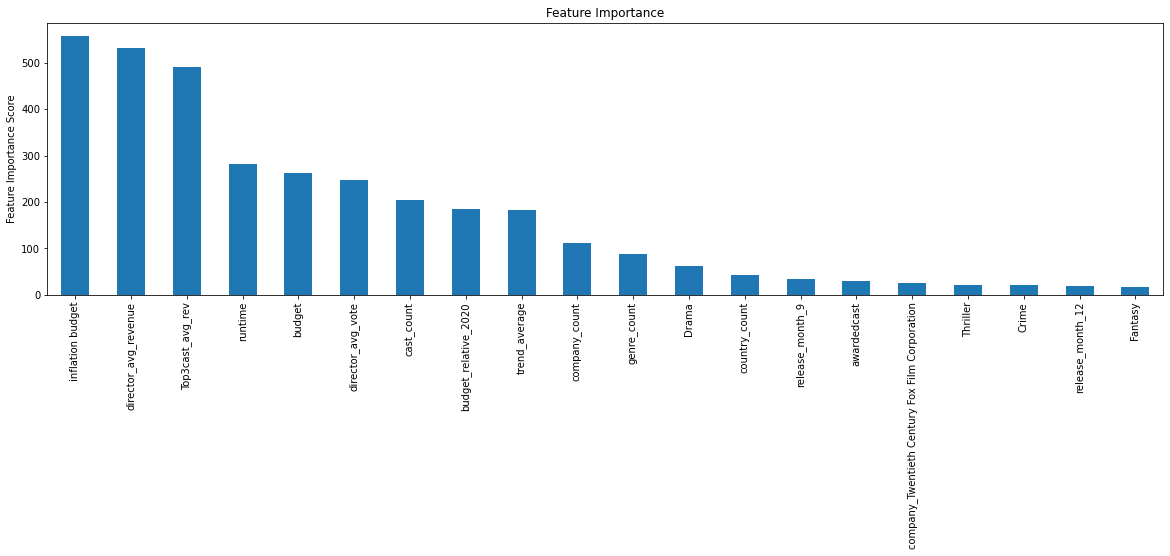

In [582]:
#Feature importance for top 50 predictors
predictors = [x for x in X.columns]
feat_imp = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:20]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [589]:
df_send = pd.DataFrame(feat_imp,columns=["Importance Value"])

In [590]:
df_send.to_csv("to_Page.csv")

In [182]:
# LGB Model Binary Classification
# Converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)
# Specifying the parameter
params={}
params['learning_rate'] = 0.02
params['boosting_type'] = 'gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth'] = 15
params["num_leaves"] = 150
params["max_bin"] = 300
# Train the model 
epoch = 10000
start = datetime.now() 
clf=lgb.train(params,d_train,epoch) #train the model on 1000 epocs
stop = datetime.now()

# Prediction on the test set
y_pred=clf.predict(X_test)



#Execution time of the model 
execution_time_lgb = stop-start 


In [183]:
execution_time_lgb

datetime.timedelta(seconds=56, microseconds=851222)

In [592]:
# Check best threshold
threshold_value = []
accuracy_value = []
y_pred2 = []
for i in np.linspace(0,1,100):
    
    threshold = i
    for z in range(X_test.shape[0]):
        if y_pred[z] >= threshold:       
            y_pred2.append(1)
        else:  
            y_pred2.append(0)
        
    threshold_value.append(i)
   
    accuracy_value.append(accuracy_score(y_pred2,y_test))
    y_pred2 = []
df_threshold = pd.DataFrame(list(zip(threshold_value,accuracy_value)), columns=["threshold","accuracy"])

df_threshold[df_threshold["accuracy"] ==  df_threshold["accuracy"].max()]

,threshold,accuracy
33,0.333333,0.799007


In [170]:
# setting threshold to number
y_pred2 = []
threshold = 0.393939
for i in range(X_test.shape[0]):
    if y_pred[i] >= threshold:       
       y_pred2.append(1)
    else:  
       y_pred2.append(0)

In [171]:
# Evaluation metricks
print('AUC of LGB classifier on test set:{:.3f}\n'.format(roc_auc_score(y_pred2,y_test)))
print('Accuracy of LGB  classifier on test set: {:.3f}\n'.format(accuracy_score(y_pred2,y_test)))
print('Precision of LGB  classifier on test set: {:.3f}\n'.format(precision_score(y_pred2,y_test)))
print('Recall of LGB  classifier on test set: {:.3f}\n'.format(recall_score(y_pred2,y_test)))
print('F1_score of LGB  classifier on test set: {:.3f}\n'.format(f1_score(y_pred2,y_test)))
print("Confusion matrix\n", confusion_matrix(y_pred2,y_test))

AUC of LGB classifier on test set:0.816

Accuracy of LGB  classifier on test set: 0.819

Precision of LGB  classifier on test set: 0.821

Recall of LGB  classifier on test set: 0.782

F1_score of LGB  classifier on test set: 0.801

Confusion matrix
 [[382  67]
 [ 86 308]]


In [172]:
# XGB Model

dtrain=xgb.DMatrix(X_train,label = y_train)
dtest=xgb.DMatrix(X_test)
#setting parameters for xgboost
params={}
params['learning_rate'] = 0.03
params['eta'] = 1
params['objective'] = "binary:logistic"
params['eval_metric']='auc' 
params['max_depth'] = 15
#params["silent"] = 1

#training our model 
epoch = 1000
 
start = datetime.now() 
clf = xgb.train(params,dtrain,epoch) 
stop = datetime.now()

#Execution time of the model 
execution_time_xgb = stop-start 


y_pred = clf.predict(dtest) 


In [173]:
execution_time_xgb

datetime.timedelta(seconds=45, microseconds=389662)

In [174]:
# Check best threshold
threshold_value = []
accuracy_value = []
y_pred2 = []
for i in np.linspace(0,1,100):
    
    threshold = i
    for z in range(X_test.shape[0]):
        if y_pred[z] >= threshold:       
            y_pred2.append(1)
        else:  
            y_pred2.append(0)
        
    threshold_value.append(i)
   
    accuracy_value.append(accuracy_score(y_pred2,y_test))
    y_pred2 = []
df_threshold = pd.DataFrame(list(zip(threshold_value,accuracy_value)), columns=["threshold","accuracy"])

df_threshold[df_threshold["accuracy"] ==  df_threshold["accuracy"].max()]

,threshold,accuracy
48,0.484848,0.825623
56,0.565657,0.825623
58,0.585859,0.825623


In [177]:
# setting threshold to number
threshold = 0.484848
for i in range(X_test.shape[0]):
    if y_pred[i] >= threshold:       
       y_pred[i] = 1
    else:  
       y_pred[i] = 0

In [178]:
# Evaluation metricks
print('AUC of XGB classifier on test set:{:.3f}\n'.format(roc_auc_score(y_pred,y_test)))
print('Accuracy of XGB  classifier on test set: {:.3f}\n'.format(accuracy_score(y_pred,y_test)))
print('Precision of XGB  classifier on test set: {:.3f}\n'.format(precision_score(y_pred,y_test)))
print('Recall of XGB  classifier on test set: {:.3f}\n'.format(recall_score(y_pred,y_test)))
print('F1_score of XGB  classifier on test set: {:.3f}\n'.format(f1_score(y_pred,y_test)))
print("Confusion matrix\n", confusion_matrix(y_pred,y_test))

AUC of XGB classifier on test set:0.820

Accuracy of XGB  classifier on test set: 0.822

Precision of XGB  classifier on test set: 0.789

Recall of XGB  classifier on test set: 0.807

F1_score of XGB  classifier on test set: 0.798

Confusion matrix
 [[397  79]
 [ 71 296]]


In [15]:
# Regression Modeling
y = df_page.loc[:,"revenue"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [18]:
# Regression
# Declaring the parameters
d_train=lgb.Dataset(X_train, label=y_train)
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='regression'#regression task
params['n_estimators']=10000
params['max_depth']=10
# Model creation and training
clf=lgb.train(params,d_train,100)
# Model prediction on X_test
y_pred=clf.predict(X_test)
# Using RMSE error metric
print('Mean Square Error of LGB Regressor on test set: {:.3f}\n'.format(mean_squared_error(y_pred,y_test)))
#print('Mean Square Log Error of LGB Regressor on test set: {:.3f}\n'.format(mean_squared_log_error(y_pred,y_test)))

Mean Square Error of LGB Regressor on test set: 5813654852231433.000



In [19]:
print('Root Mean Square Error of LGB Regressor on test set: {:.3f}\n'.format(mean_squared_error(y_pred,y_test)**0.5))

Root Mean Square Error of LGB Regressor on test set: 76247326.853



In [22]:
for i,z in zip(y_pred,y_test):
    print(i - z)

-2644478.875204012
71757006.20524225
-6562390.316825496
93523974.70075205
-55396167.33385609
-114899975.69378771
5192736.543917879
-30495748.903686307
-18102408.824344993
22638486.513827115
6993145.67388065
2077637.0334070828
-1148148.9335425645
-14075649.689119127
4425696.600299738
46646910.88942866
5069939.780679718
-3652099.7349905223
-44170988.87717167
135068915.37785575
115048.19052671641
2874075.6232017856
17221329.179210097
118884933.05568081
157465634.26013112
357898.97550301
36364530.1720072
-31864479.225242533
-124516563.32285902
31932522.48360908
21314406.904341474
19247851.59384837
362631599.5977732
12259834.173413008
-21076678.773154184
7649714.720696241
12462279.358833753
-61150685.30132839
16012925.284153506
34432442.702265374
-16528331.912382944
-161792299.00399694
-83119939.0994811
-634424.0409271792
-5491851.971313804
75017526.09850694
10678594.653203502
-24778.24169871956
38150469.82576892
12775399.825939506
-12377387.085183494
978504.1733179986
76931185.7837241
7897

In [3]:
df_master = pd.read_csv("Master.csv")

In [69]:
df_master = pd.read_csv("MasterGT.csv")

In [134]:
df_master = pd.read_csv("MasterFinal.csv")

In [135]:
df_master.shape

(8133, 184)

In [136]:
pd.set_option('display.max_columns', 500)


In [137]:
df_master.head(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,title,id,release_date,year,Director Ind,budget,runtime,director_median_vote,director_median_revenue,Top3cast_median_revenue,budget_inflation_reverse,budget_inflation_to2020,Director_Number,country_count,genre_count,company_count,cast_count,awardedcast,book,country_Angola,country_Argentina,country_Australia,country_Austria,country_Bahamas,country_Belarus,country_Belgium,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Costa Rica,country_Croatia,country_Czech Republic,country_Denmark,country_Ecuador,country_Egypt,country_Estonia,country_Finland,country_France,country_Germany,country_Gibraltar,country_Greece,country_Guatemala,country_Hong Kong,country_Hungary,country_Iceland,country_India,country_Iran,country_Ireland,country_Israel,country_Italy,country_Jamaica,country_Japan,country_Kazakhstan,country_Latvia,country_Liechtenstein,country_Lithuania,country_Luxembourg,country_Macedonia,country_Malaysia,country_Mali,country_Malta,country_Mexico,country_Monaco,country_Morocco,country_Namibia,country_Netherlands,country_New Zealand,country_Norway,country_Pakistan,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Puerto Rico,country_Qatar,country_Romania,country_Russia,country_Serbia,country_Singapore,country_Slovenia,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_Switzerland,country_Taiwan,country_Thailand,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States of America,country_Uruguay,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western,company_Amblin Entertainment,company_BBC Films,company_Canal+,company_Castle Rock Entertainment,company_Columbia Pictures,company_Columbia Pictures Corporation,company_Davis Entertainment,company_Dimension Films,company_DreamWorks SKG,company_Dune Entertainment,company_Epsilon Motion Pictures,company_EuropaCorp,company_Focus Features,company_Fox 2000 Pictures,company_Fox Searchlight Pictures,company_France 2 Cinéma,company_Hollywood Pictures,company_Imagine Entertainment,company_Lions Gate Films,company_Lionsgate,company_Lucasfilm,company_Metro-Goldwyn-Mayer (MGM),company_Millennium Films,company_Miramax Films,company_Morgan Creek Productions,company_New Line Cinema,company_Orion Pictures,company_Paramount Pictures,company_PolyGram Filmed Entertainment,company_Regency Enterprises,company_Relativity Media,company_Revolution Studios,company_Scott Rudin Productions,company_Screen Gems,company_Silver Pictures,company_Spyglass Entertainment,company_StudioCanal,company_Summit Entertainment,company_The Weinstein Company,company_Touchstone Pictures,company_TriStar Pictures,company_Twentieth Century Fox Film Corporation,company_United Artists,company_Universal Pictures,company_Village Roadshow Pictures,company_Walt Disney Pictures,company_Walt Disney Productions,company_Warner Bros.,company_Working Title Films,company_others,revenue,trend_average,isenglish,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
0,0,0,0,Toy Story,862,1995-10-30,1995.0,John Lasseter,30000000,81.0,7.4,378405584.5,219417255.0,1.732676e+07,5.194277e+07,1.0,1,3,1,13.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,373554033.0,13.877483,1,0,0,0,0,0,0,0,0,0,1,0,0


In [138]:
df_master.shape

(8133, 184)

In [139]:
col_to_drop = ["Unnamed: 0","title","id","release_date","year","Director Ind","Unnamed: 0.1","trend_average","Unnamed: 0.1.1"]

In [140]:
df_master = df_master.drop(col_to_drop,axis=1)

In [141]:
X = df_master.drop("revenue",axis=1)

In [142]:
df_master['profit'] = df_master["revenue"] - 3 * df_master["budget"]
df_master["target"] = df_master["profit"].apply(lambda x: 1 if x >= 0 else 0)
df_master["target"].value_counts()

0    6303
1    1830
Name: target, dtype: int64

In [143]:
y = df_master["target"]

In [144]:
X_scaled_std = StandardScaler().fit_transform(X)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_std,y, random_state=0)

In [128]:
# # grid of parameters
# gridParams = {
#    'learning_rate': [0.01,0.02,0.03,0.04,0.05],
#    'num_leaves': [90,150,200],
#    'boosting_type' : ['gbdt'],
#    'objective' : ['binary'],
#    'max_depth' : [5,6,7,8],
#    'random_state' : [501], 
#    'colsample_bytree' : [0.5,0.7],
#    'subsample' : [0.5,0.7],
#    'min_split_gain' : [0.01],
#    'min_data_in_leaf':[10],
#    'metric':['auc']
#    }

# clf = lgb.LGBMRegressor()
# grid = GridSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1)
# grid.fit(X_train,y_train)

# grid.best_params_

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  9.4min finished


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 8,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'num_leaves': 90,
 'objective': 'binary',
 'random_state': 501,
 'subsample': 0.5}

In [131]:
# # grid of parameters
# gridParams = {
#    'learning_rate': [0.45,0.05,0.55,0.6],
#    'num_leaves': [90,100,110],
#    'boosting_type' : ['gbdt'],
#    'objective' : ['binary'],
#    'max_depth' : [8,9,10,11],
#    'random_state' : [501], 
#    'colsample_bytree' : [0.7,0.8],
#    'subsample' : [0.5,0.6],
#    'min_split_gain' : [0.01],
#    'min_data_in_leaf':[10],
#    'metric':['auc']
#    }

# clf = lgb.LGBMRegressor()
# grid = GridSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1)
# grid.fit(X_train,y_train)

# grid.best_params_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  7.8min finished


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 10,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'num_leaves': 100,
 'objective': 'binary',
 'random_state': 501,
 'subsample': 0.5}

In [149]:
gridParams = {
    'boosting_type': ['gbdt'],
    'colsample_bytree': [0.7],
    'learning_rate': [0.05],
    'max_depth': [10],
    'metric': ['auc'],
    'min_data_in_leaf': [10],
    'min_split_gain': [0.01],
    'num_leaves': [100],
    'objective': ['binary'],
    'random_state': [501],
    'subsample': [0.5]}

clf = lgb.LGBMRegressor()
grid = GridSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1)
grid.fit(X_train,y_train)

grid.best_params_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 10,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'num_leaves': 100,
 'objective': 'binary',
 'random_state': 501,
 'subsample': 0.5}

In [150]:
y_pred = grid.predict(X_test)

In [151]:
# Check best threshold
threshold_value = []
accuracy_value = []
y_pred2 = []
for i in np.linspace(0,1,100):
    
    threshold = i
    for z in range(X_test.shape[0]):
        if y_pred[z] >= threshold:       
            y_pred2.append(1)
        else:  
            y_pred2.append(0)
        
    threshold_value.append(i)
   
    accuracy_value.append(accuracy_score(y_pred2,y_test))
    y_pred2 = []
df_threshold = pd.DataFrame(list(zip(threshold_value,accuracy_value)), columns=["threshold","accuracy"])

df_threshold[df_threshold["accuracy"] ==  df_threshold["accuracy"].max()]

,threshold,accuracy
47,0.474747,0.886922


In [152]:
# setting threshold to number
y_pred2 = []
threshold = 0.474747
for i in range(X_test.shape[0]):
    if y_pred[i] >= threshold:       
       y_pred2.append(1)
    else:  
       y_pred2.append(0)

In [153]:
# Evaluation metricks
print('AUC of LGB classifier on test set:{:.3f}\n'.format(roc_auc_score(y_test,y_pred)))
print('Accuracy of LGB  classifier on test set: {:.3f}\n'.format(accuracy_score(y_test,y_pred2)))
print('Precision of LGB  classifier on test set: {:.3f}\n'.format(precision_score(y_test,y_pred2)))
print('Recall of LGB  classifier on test set: {:.3f}\n'.format(recall_score(y_test,y_pred2)))
print('F1_score of LGB  classifier on test set: {:.3f}\n'.format(f1_score(y_test,y_pred2)))
print("Confusion matrix\n", confusion_matrix(y_test,y_pred2))

AUC of LGB classifier on test set:0.924

Accuracy of LGB  classifier on test set: 0.887

Precision of LGB  classifier on test set: 0.808

Recall of LGB  classifier on test set: 0.670

F1_score of LGB  classifier on test set: 0.733

Confusion matrix
 [[1489   75]
 [ 155  315]]


Text(0, 0.5, 'Feature Importance Score')

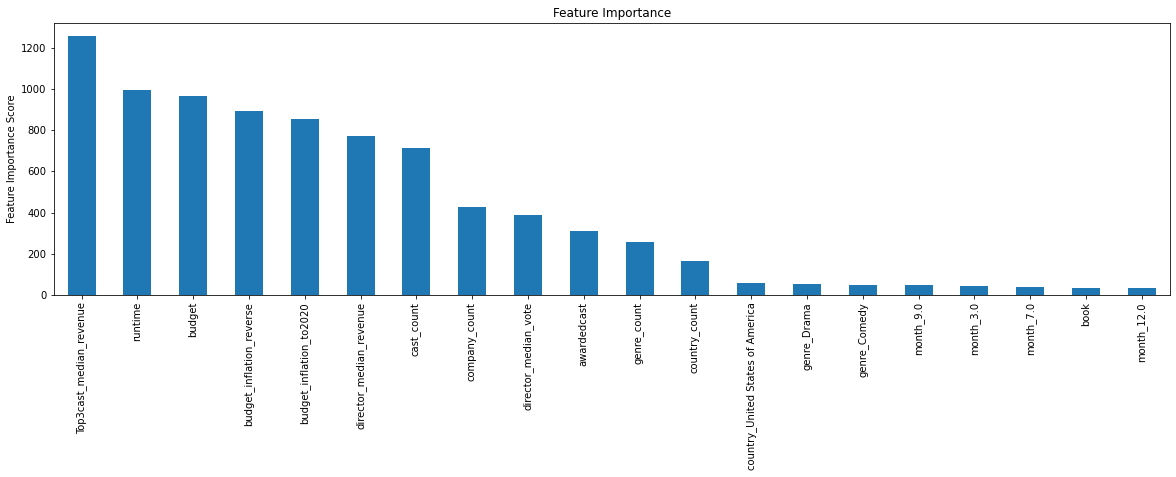

In [154]:
#Feature importance for top 50 predictors
predictors = [x for x in X.columns]
feat_imp = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:20]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')